# UB DataScience: Complex networks
### David Solans & Gerard Martinez

In [17]:

import networkx as nx
import matplotlib.pyplot as plt
from multiprocessing import Pool
import itertools
from networkx.algorithms import community
import collections
import numpy as np
import pickle
import operator
import folium
from scipy.optimize import curve_fit

plt.style.use('seaborn')

%matplotlib inline

## Loading data

In [18]:
G_transport = nx.read_edgelist("barcelona_transport.edgelist", create_using = nx.Graph(), nodetype = int)
G_bus = nx.read_edgelist("barcelona_bus.edgelist", create_using = nx.Graph(), nodetype = int)
G_metro = nx.read_edgelist("barcelona_metro.edgelist", create_using = nx.Graph(), nodetype = int)

In [19]:
def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [20]:
bus_stations_properties = load_obj("bus_stations_properties")

## Week 5 - Mesoscale

### Communities detection

In [112]:
## Plot communities
def plot_communities(G, partitions, title):
    # Plot, color nodes using community structure
    values = [partitions.get(node) for node in G.nodes()]
    nx.draw_spring(G, cmap=plt.get_cmap('jet'), node_color = values, node_size=30, with_labels=False)
    plt.title(title)
    
    print("Modularity: %s" % community.modularity(partitions,G))
    print("Total number of communities: %i" % len(set(val for val in partitions.values())))
    print("Total number of nodes: %i" % len(partitions.values()))
   
    plt.show()


In [113]:
## Partition to dict
def partition_to_dict(partitions, G):
    result = {}
    c = 0
    
    for partition_idx, partitions in enumerate(partitions):
        for j in list(partitions):
            result[j] = partition_idx
        c+=1
            
            
    for n in G.nodes():
        if n not in result:
            result[n] = c
            c+=1

    return result

#### Cliques

In [66]:
MAX_CLICKES = 5

num_clickes = []
for i in range(2,MAX_CLICKES):
    c = list(nx.algorithms.community.k_clique_communities(G_bus, i))
    num_clickes.append(c)
    print("Num clickes size %i --> %i" % (i ,len([item for sublist in c for item in sublist])))
    


Num clickes size 2 --> 2469
Num clickes size 3 --> 80
Num clickes size 4 --> 0


#### Bipartition

bipartition = nx.algorithms.community.kernighan_lin_bisection(G_bus)

In [ ]:
### Check modularity. If not found, consider using code from networkx dev version: 
##                    https://networkx.github.io/documentation/latest/_modules/networkx/algorithms/community/quality.html
bipartition_modularity = nx.algorithms.community.quality.modularity(G_bus, bipartition)

### Check coverage
bipartition_coverage = nx.algorithms.community.quality.coverage(G_bus, bipartition)

### Check performance
bipartition_modularity = nx.algorithms.community.quality.performance(G_bus, bipartition)

<div class="alert alert-block alert-warning">
<b>Bipartion</b>
<p>Takes too long to be calculated!</p>
</div>

#### Label propagation

Generates community sets determined by label propagation

Finds communities in G_bus using a semi-synchronous label propagation method. This method combines the advantages of both the synchronous and asynchronous models.

In [93]:
label_prop_partition = nx.algorithms.community.label_propagation_communities(G_bus)

In [94]:
label_prop_partition_dict = partition_to_dict(label_prop_partition, G_bus)

Modularity: 0.5073809110106872
Total number of communities: 916
Total number of nodes: 2469


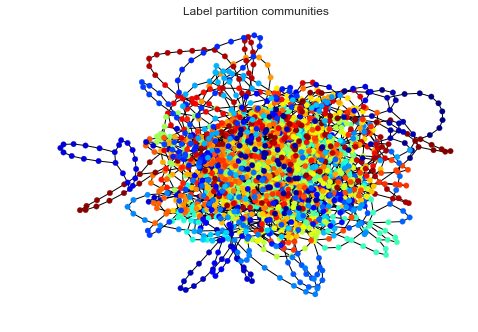

In [98]:
plot_communities(G_bus, label_prop_partition_dict, "Label partition communities")

#### Fluid communities

In [114]:
fluid_communities_partitions = nx.algorithms.community.asyn_fluidc(list(nx.connected_component_subgraphs(G_bus))[0], 1000)

In [116]:
fluid_communities_dict = partition_to_dict(fluid_communities_partitions, G_bus)

Modularity: 0.435998492145073
Total number of communities: 1112
Total number of nodes: 2469


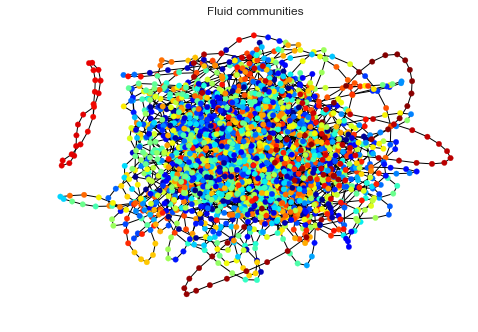

In [117]:
plot_communities(G_bus, fluid_communities_dict, "Fluid communities")

#### Louvain

Compute the partition of the graph nodes which maximises the modularity (or try..) using the Louvain heuristices

This is the partition of highest modularity, i.e. the highest partition of the dendrogram generated by the Louvain algorithm.

Modularity: 0.8538385513220372
Total number of communities: 30
Total number of nodes: 2469


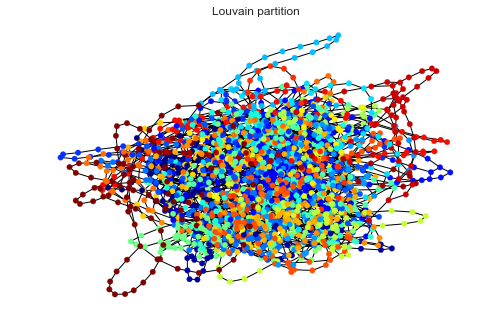

In [111]:
louvain_partition = community.best_partition(G_bus)

plot_communities(G_bus, louvain_partition, "Louvain partition")


In [28]:
modularity = {} # Create a new, empty dictionary
for k,v in louvain_partition.items(): # Loop through the community dictionary
    if v not in modularity:
        modularity[v] = [k] # Add a new key for a modularity class the code hasn't seen before
    else:
        modularity[v].append(k) # Append a name to the list for a modularity class the code has already seen

for k,v in modularity.items(): # Loop through the new dictionary
    if len(v) > 2: # Filter out modularity classes with 2 or fewer nodes
        print('Class '+str(k)+':', v) # Print out the classes and their members

Class 0: [1788, 274, 273, 1286, 1281, 1285, 1283, 413, 2162, 277, 1879, 2262, 578, 698, 1631, 802, 36, 697, 864, 2889, 1109, 1302, 1125, 829, 1628, 830, 682, 2741, 1662, 1, 543, 794, 1274, 2258, 2289, 1899, 2688, 2689, 2268, 1898, 1897, 1896, 2740, 2897, 1630, 2910, 301, 1277, 2723, 34, 1273, 31, 827, 2134, 2659, 1131, 399, 2898, 2899, 2909, 2908, 2907, 2264, 2263, 2265, 2657, 1090, 1763, 33, 700, 300, 143, 2772, 3190, 382, 2700, 1128, 1616, 2293, 2347, 2986, 2983, 191, 2751, 2698, 2699, 2294, 2295, 837, 1632, 2283, 2284, 2151, 2266, 2253, 1764, 2, 1629, 342, 2731, 1022, 303, 1579, 2582, 2530, 835, 2730, 2464]
Class 1: [3286, 181, 1365, 1364, 1767, 1768, 1756, 856, 1373, 1713, 1361, 1753, 2982, 2368, 1259, 2984, 179, 584, 708, 707, 1766, 1755, 1239, 778, 1754, 831, 21, 458, 547, 548, 766, 2541, 2992, 237, 2259, 1890, 1891, 1892, 1893, 1894, 765, 310, 2543, 2542, 299, 1650, 295, 2685, 1238, 854, 2548, 2392, 2399, 296, 937, 2681, 764, 549, 1946, 172, 550, 552, 1021, 294, 591, 2919, 1484,

#### Girvan Newman

Finds communities in a graph using the Girvan–Newman method.

In [ ]:
girvan_newman_partitions = nx.algorithms.community.centrality.girvan_newman(G_bus)

In [ ]:
girvan_newman_partitions_dict = partition_to_dict([p[0] for p in girvan_newman_partitions], G_bus)

In [ ]:
plot_communities(G_bus, girvan_newman_partitions_dict, "Girvan Newman")

To stop getting tuples of communities once the number of communities is greater than k, use itertools.takewhile():

In [31]:
import itertools
#G = nx.path_graph(8)
k = 6
comp = nx.algorithms.community.centrality.girvan_newman(G_bus)
limited = itertools.takewhile(lambda c: len(c) <= k, comp)
for communities in limited:
    print(tuple(sorted(c) for c in communities)) 


([1, 2, 3, 4, 5, 6, 7, 8, 12, 13, 15, 16, 17, 18, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 36, 38, 39, 40, 41, 42, 43, 44, 47, 48, 49, 50, 51, 52, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 65, 69, 70, 71, 73, 74, 76, 79, 80, 81, 82, 83, 84, 85, 86, 87, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 102, 103, 105, 106, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 125, 126, 127, 128, 129, 130, 131, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 146, 147, 148, 149, 150, 152, 153, 154, 156, 158, 159, 161, 162, 163, 164, 165, 166, 167, 168, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 185, 187, 189, 191, 193, 195, 196, 198, 199, 200, 202, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 216, 217, 218, 219, 220, 221, 222, 224, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 239, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 261, 262, 263, 264, 265, 266, 26

KeyboardInterrupt: 